In [33]:
import os
import kagglehub
import pandas as pd
import re
import string
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)
print("Fichiers présents dans le dataset :")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

# Charger les deux fichiers
telco_churn = pd.read_csv(os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv"))

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1
Fichiers présents dans le dataset :
C:\Users\User\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1\WA_Fn-UseC_-Telco-Customer-Churn.csv


## Exploration des données (EDA)

In [35]:
telco_churn.info()
telco_churn.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [36]:
telco_churn['TotalCharges'] = pd.to_numeric(telco_churn['TotalCharges'], errors='coerce')


In [37]:
print(telco_churn['TotalCharges'].isna().sum())  # Si > 0, à gérer (suppression ou imputation)

11


In [38]:
if telco_churn['SeniorCitizen'].dropna().isin([0, 1]).all():
    telco_churn['SeniorCitizen'] = telco_churn['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [39]:
print(telco_churn['Churn'].value_counts(normalize=True) * 100)

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [40]:
telco_churn.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [41]:
telco_churn['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

In [42]:
# Recalcul du tableau genre/churn
gender_churn = telco_churn.groupby(['Churn', 'gender']).size().reset_index(name='count')
gender_churn['percentage'] = gender_churn.groupby('Churn')['count'].transform(lambda x: round((x / x.sum()) * 100, 2))
print(gender_churn)

  Churn  gender  count  percentage
0    No  Female   2549       49.27
1    No    Male   2625       50.73
2   Yes  Female    939       50.24
3   Yes    Male    930       49.76


In [43]:
churn_counts = telco_churn['Churn'].value_counts().reset_index()
churn_counts.columns = ['churn_status', 'customer_count']
churn_counts['percentage'] = round(
    churn_counts['customer_count'] / churn_counts['customer_count'].sum() * 100, 2
)
print("=== Répartition churn global ===")
print(churn_counts)

=== Répartition churn global ===
  churn_status  customer_count  percentage
0           No            5174       73.46
1          Yes            1869       26.54


In [44]:
SeniorCitizen_churn = telco_churn.groupby(['Churn', 'SeniorCitizen']).size().reset_index(name='count')
SeniorCitizen_churn['percentage'] = SeniorCitizen_churn.groupby('Churn')['count'].transform(
    lambda x: round((x / x.sum()) * 100, 2)
)
print("\n=== Répartition par SeniorCitizen et churn ===")
print(SeniorCitizen_churn)


=== Répartition par SeniorCitizen et churn ===
  Churn SeniorCitizen  count  percentage
0    No            No   4508       87.13
1    No           Yes    666       12.87
2   Yes            No   1393       74.53
3   Yes           Yes    476       25.47


In [45]:
# Fonction pour générer analyse count + pourcentage
def churn_categorical_analysis(df, column):
    churn_df = df.groupby(['Churn', column]).size().reset_index(name='count')
    churn_df['percentage'] = churn_df.groupby('Churn')['count'].transform(
        lambda x: round((x / x.sum()) * 100, 2)
    )
    print(f"\n=== Répartition par '{column}' et churn ===")
    print(churn_df)

# Liste des colonnes à analyser
categorical_columns = [
    'Contract', 'InternetService', 'OnlineSecurity', 'TechSupport',
    'PaymentMethod', 'PaperlessBilling', 'Partner', 'Dependents',
    'StreamingTV', 'StreamingMovies'
]

# Appliquer la fonction
for col in categorical_columns:
    churn_categorical_analysis(telco_churn, col)


=== Répartition par 'Contract' et churn ===
  Churn        Contract  count  percentage
0    No  Month-to-month   2220       42.91
1    No        One year   1307       25.26
2    No        Two year   1647       31.83
3   Yes  Month-to-month   1655       88.55
4   Yes        One year    166        8.88
5   Yes        Two year     48        2.57

=== Répartition par 'InternetService' et churn ===
  Churn InternetService  count  percentage
0    No             DSL   1962       37.92
1    No     Fiber optic   1799       34.77
2    No              No   1413       27.31
3   Yes             DSL    459       24.56
4   Yes     Fiber optic   1297       69.40
5   Yes              No    113        6.05



=== Répartition par 'OnlineSecurity' et churn ===
  Churn       OnlineSecurity  count  percentage
0    No                   No   2037       39.37
1    No  No internet service   1413       27.31
2    No                  Yes   1724       33.32
3   Yes                   No   1461       78.17
4   Yes  No internet service    113        6.05
5   Yes                  Yes    295       15.78

=== Répartition par 'TechSupport' et churn ===
  Churn          TechSupport  count  percentage
0    No                   No   2027       39.18
1    No  No internet service   1413       27.31
2    No                  Yes   1734       33.51
3   Yes                   No   1446       77.37
4   Yes  No internet service    113        6.05
5   Yes                  Yes    310       16.59

=== Répartition par 'PaymentMethod' et churn ===
  Churn              PaymentMethod  count  percentage
0    No  Bank transfer (automatic)   1286       24.86
1    No    Credit card (automatic)   1290       24.93
2    No          

In [46]:
# Colonnes numériques
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Assurer que TotalCharges est bien numérique
telco_churn['TotalCharges'] = pd.to_numeric(telco_churn['TotalCharges'], errors='coerce')

# Calcul des stats
metrics_churn = telco_churn.groupby('Churn')[numerical_columns].agg(['mean', 'std'])
metrics_churn.columns = ['_'.join(col) for col in metrics_churn.columns]  # Flatten
metrics_churn = metrics_churn.reset_index()

# Affichage
print("\n=== Moyenne et écart-type des variables numériques par churn ===")
print(metrics_churn)



=== Moyenne et écart-type des variables numériques par churn ===
  Churn  tenure_mean  tenure_std  MonthlyCharges_mean  MonthlyCharges_std  \
0    No    37.569965   24.113777            61.265124           31.092648   
1   Yes    17.979133   19.531123            74.441332           24.666053   

   TotalCharges_mean  TotalCharges_std  
0        2555.344141       2329.456984  
1        1531.796094       1890.822994  


## Préparation des données : Oversampling de la classe minoritaire (Churn = Yes)

In [ ]:
# 1. Supprimer les colonnes inutiles

telco_churn.drop('customerID', axis=1, inplace=True)

# 2. Convertir TotalCharges en numérique (certaines valeurs sont probablement des chaînes vides)
telco_churn['TotalCharges'] = pd.to_numeric(telco_churn['TotalCharges'], errors='coerce')

# 3. Supprimer les lignes avec des valeurs manquantes
telco_churn.dropna(inplace=True)

# # 4. Encoder la cible
# telco_churn['Churn'] = telco_churn['Churn'].map({'No': 0, 'Yes': 1})

# if telco_churn['Churn'].dropna().isin([0, 1]).all():
#     telco_churn['Churn'] = telco_churn['Churn'].map({0: 'No', 1: 'Yes'})

# 5. Séparer les features et la cible
X = telco_churn.drop('Churn', axis=1)
y = telco_churn['Churn']

# 6. Encoder les variables catégorielles (avec get_dummies)
X = pd.get_dummies(X, drop_first=True)


In [49]:
from imblearn.over_sampling import SMOTE  # ou RandomOverSampler
from sklearn.model_selection import train_test_split

# Supposons que X et y soient déjà prêts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Appliquer SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Avant rééchantillonnage :", y_train.value_counts())
print("Après SMOTE :", y_train_res.value_counts())


Avant rééchantillonnage : Churn
No     4130
Yes    1495
Name: count, dtype: int64
Après SMOTE : Churn
No     4130
Yes    4130
Name: count, dtype: int64


##  Modélisation (Machine Learning) / Évaluation

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Entraînement
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)

# Prédictions
y_pred = rf.predict(X_test)

# Évaluation
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# Score AUC
y_prob = rf.predict_proba(X_test)[:,1]
print("AUC-ROC Score:", round(roc_auc_score(y_test, y_prob), 4))


=== Classification Report ===
              precision    recall  f1-score   support

          No       0.86      0.84      0.85      1033
         Yes       0.58      0.61      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407

=== Confusion Matrix ===
[[868 165]
 [146 228]]
AUC-ROC Score: 0.8174


## Interprétation / Visualisation / Communication

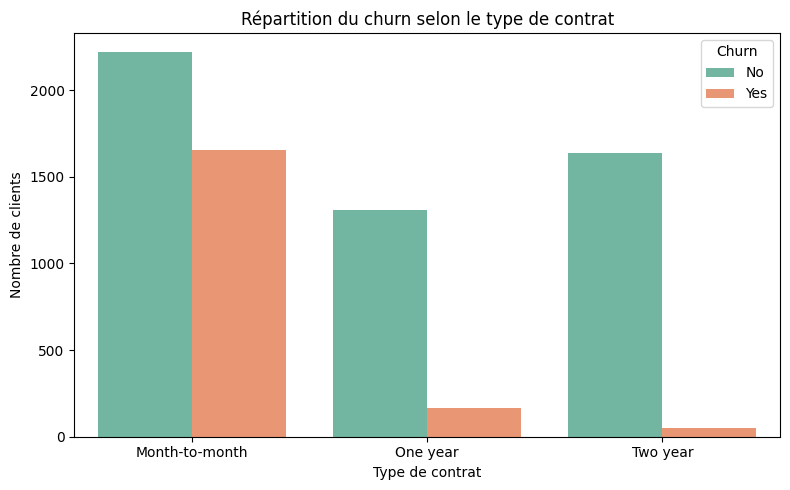

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=telco_churn, x='Contract', hue='Churn', palette='Set2')
plt.title("Répartition du churn selon le type de contrat")
plt.ylabel("Nombre de clients")
plt.xlabel("Type de contrat")
plt.legend(title="Churn")
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_16892\1709708246.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=telco_churn, x='Churn', y='MonthlyCharges', palette='Set3')


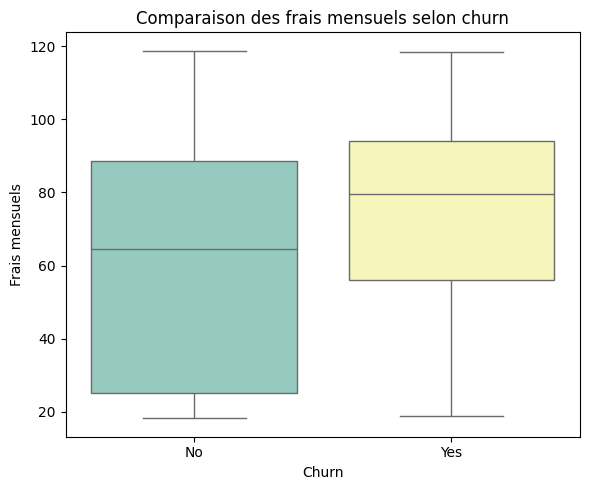

In [52]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=telco_churn, x='Churn', y='MonthlyCharges', palette='Set3')
plt.title("Comparaison des frais mensuels selon churn")
plt.ylabel("Frais mensuels")
plt.xlabel("Churn")
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_16892\393038003.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=telco_churn, x='Churn', y='tenure', palette='Set1')


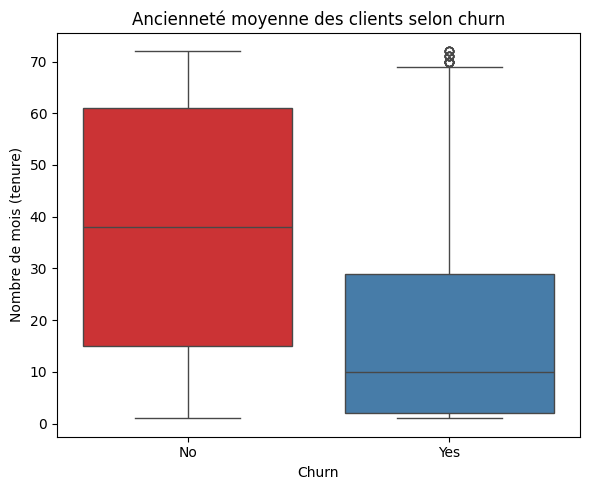

In [53]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=telco_churn, x='Churn', y='tenure', palette='Set1')
plt.title("Ancienneté moyenne des clients selon churn")
plt.ylabel("Nombre de mois (tenure)")
plt.xlabel("Churn")
plt.tight_layout()
plt.show()

In [54]:
from sklearn.preprocessing import LabelEncoder

# Copie du DataFrame original
df_encoded = telco_churn.copy()

# Encodage de la variable cible
df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

# Encodage des colonnes catégorielles automatiquement
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != 'customerID':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])


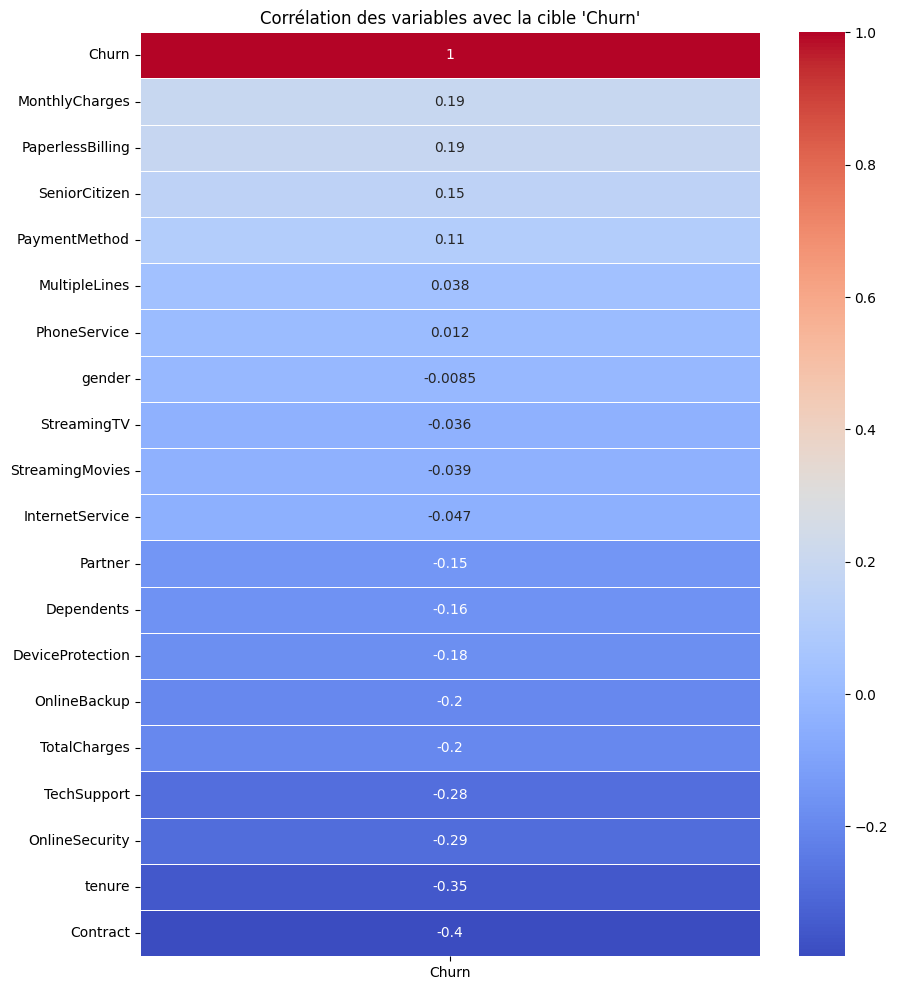

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_encoded.corr()

plt.figure(figsize=(10, 12))
sns.heatmap(corr[['Churn']].sort_values(by='Churn', ascending=False), 
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Corrélation des variables avec la cible 'Churn'")
plt.show() 


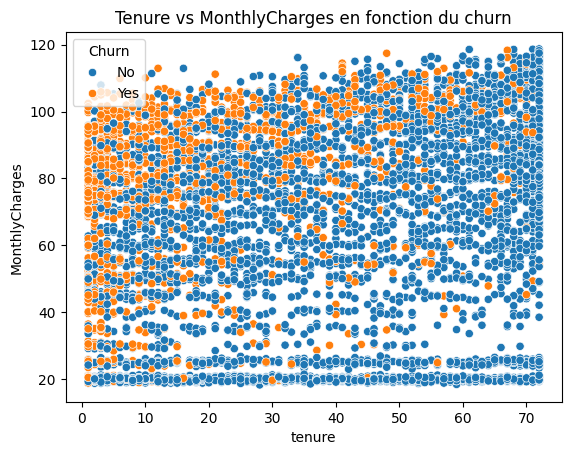

In [56]:
sns.scatterplot(data=telco_churn, x='tenure', y='MonthlyCharges', hue='Churn')
plt.title("Tenure vs MonthlyCharges en fonction du churn")
plt.show()


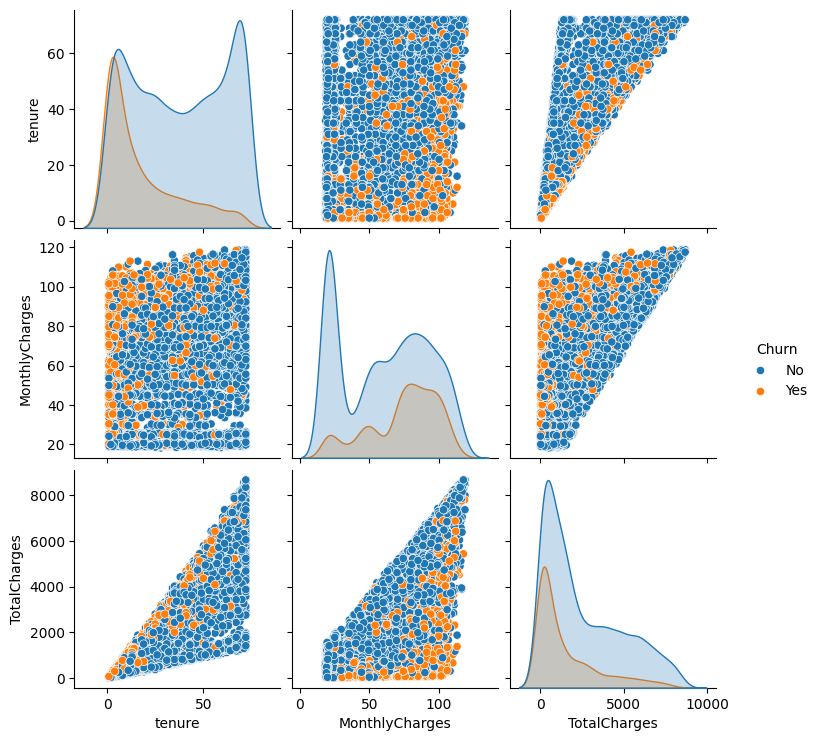

In [57]:
sns.pairplot(data=telco_churn, hue='Churn', vars=['tenure', 'MonthlyCharges', 'TotalCharges'])


Hypothèse visuelle : Les churners ont une ancienneté plus faible.

In [60]:
print("Ancienneté moyenne (tenure) :")
print(telco_churn.groupby('Churn')['tenure'].agg(['mean', 'std', 'median']))

Ancienneté moyenne (tenure) :
            mean        std  median
Churn                              
No     37.650010  24.076940    38.0
Yes    17.979133  19.531123    10.0


Hypothèse visuelle : Les churners paient davantage chaque mois.

In [61]:
print("Frais mensuels moyens :")
print(telco_churn.groupby('Churn')['MonthlyCharges'].agg(['mean', 'std', 'median']))

Frais mensuels moyens :
            mean        std  median
Churn                              
No     61.307408  31.094557   64.45
Yes    74.441332  24.666053   79.65


Hypothèse visuelle : Les churners ont moins dépensé (car moins restés).

In [62]:
telco_churn['TotalCharges'] = pd.to_numeric(telco_churn['TotalCharges'], errors='coerce')
print("Total payé (TotalCharges) :")
print(telco_churn.groupby('Churn')['TotalCharges'].agg(['mean', 'std', 'median']))


Total payé (TotalCharges) :
              mean          std   median
Churn                                   
No     2555.344141  2329.456984  1683.60
Yes    1531.796094  1890.822994   703.55
